# A/B–тестирование
### Условие

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

###  Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
### Вопросы

Задачи:

- Определить метрики
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?


Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла **groups_add.csv** (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import datetime as dt
%matplotlib inline 
import calendar
from tqdm.auto import tqdm
from scipy.stats import norm 
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene, chi2_contingency
import statsmodels.api as sm
from datetime import datetime
import pandahouse as ph
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pingouin as pg

# Задание 1. A/B–тестирование

In [2]:
# file with information about the user's belonging to the control or experimental group (A - control, B - target group) 
groups = pd.read_csv('groups.csv', sep=';')
#an additional file with users that was sent to you 2 days after the data transfer
group_add = pd.read_csv('group_add.csv')
# file with information about users who logged into the platform on the days of the experiment
active_studs = pd.read_csv('active_studs.csv', sep=';')
# file with information about user payments on the days of the experiment
checks = pd.read_csv('checks.csv', sep=';')

In [73]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

checks.rename(columns={'student_id': 'id'}, inplace=True)

### table: groups

In [76]:
print('Количество строк:', groups.shape[0],'\n')
print('Кол-во пропущенных значений id:', groups.id.isna().sum(),'\n')
print('Кол-во пропущенных значений grp:', groups.grp.isna().sum(),'\n')
print('Уникальных id в датасете:', groups.id.nunique(),'\n')

if groups.shape[0] ==  groups.id.nunique():
    print('Note: Все значения id уникальны')
else:
    print('Note: Осторожно, есть повторы')

Количество строк: 74484 

Кол-во пропущенных значений id: 0 

Кол-во пропущенных значений grp: 0 

Уникальных id в датасете: 74484 

Note: Все значения id уникальны


### table: group_add

In [77]:
print('Количество строк:', group_add.shape[0],'\n')
print('Кол-во пропущенных значений id:', group_add.id.isna().sum(),'\n')
print('Кол-во пропущенных значений grp:', group_add.grp.isna().sum(), '\n')
print('Уникальных id в датасете:', group_add.id.nunique(),'\n')

if group_add.shape[0] ==  group_add.id.nunique():
    print('Note: Все значения id уникальны')
else:
    print('Note: Осторожно, есть повторы')

Количество строк: 92 

Кол-во пропущенных значений id: 0 

Кол-во пропущенных значений grp: 0 

Уникальных id в датасете: 92 

Note: Все значения id уникальны


#### Объединение таблиц groups, group_add

In [78]:
general = pd.concat([groups, group_add])

In [79]:
print('Количество строк:', general.shape[0],'\n')
print('Кол-во пропущенных значений id:', general.id.isna().sum(),'\n')
print('Кол-во пропущенных значений grp:', general.grp.isna().sum(),'\n')
print('Уникальных id в датасете:', general.id.nunique(),'\n')

if general.shape[0] ==  general.id.nunique():
    print('Note: Все значения id уникальны')
else:
    print('Note: Осторожно, есть повторы')

Количество строк: 74576 

Кол-во пропущенных значений id: 0 

Кол-во пропущенных значений grp: 0 

Уникальных id в датасете: 74576 

Note: Все значения id уникальны


In [80]:
print('Количество строк было:', group_add.id.count() + groups.id.count(), 
      '\nКоличество строк после соединения:', pd.concat([groups, group_add]).id.count())
if  (group_add.id.count() + groups.id.count()) == general.id.count():
    print('Верно')
else:
    print('ERROR')

Количество строк было: 74576 
Количество строк после соединения: 74576
Верно


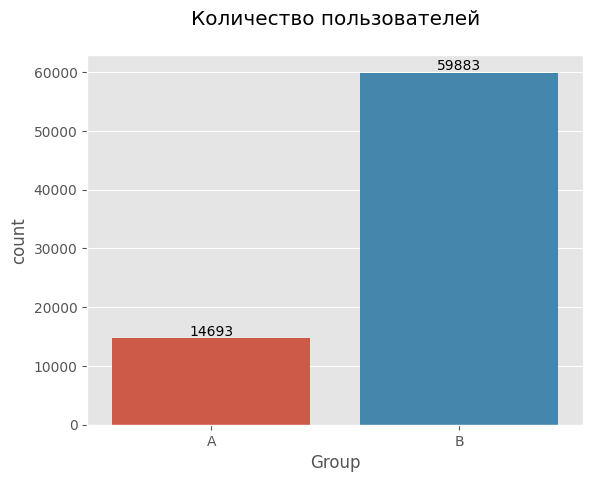

In [81]:
ax = sns.countplot(x = general['grp'].sort_values())
ax.set_title('Количество пользователей\n')
ax.set_xlabel('Group')

for container in ax.containers:
    ax.bar_label(container)

In [82]:
# Считаем процентное соотношение людей в группах.
general.grp.value_counts(normalize=True).mul(100).round(2)

B    80.3
A    19.7
Name: grp, dtype: float64

В контрольной группе (А) 14693 чел ~ **19.7 %**, в тестовой (B) – 59883 чел ~ **80.3 %**.

 Полученное распределение по группам выглядит немного странно

#### table: active_studs

In [83]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [84]:
print('Количество строк:', active_studs.shape[0],'\n')
print('Уникальных id в датасете:', active_studs.id.nunique(),'\n')

Количество строк: 8341 

Уникальных id в датасете: 8341 



все ли id из active_studs встречаются в general

In [85]:
active_studs.id.isin(general.id).value_counts()

True    8341
Name: id, dtype: int64

#### table: checks

In [86]:
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [87]:
print('Количество строк:', checks.shape[0],'\n')
print('Кол-во пропущенных значений id:', checks.id.isna().sum(),'\n')
print('Кол-во пропущенных значений rev:', checks.rev.isna().sum(),'\n')
print('Уникальных id в датасете:', checks.id.nunique(),'\n')
print('Уникальных повторов id в датасете:', checks.id.duplicated().sum(),'\n')

Количество строк: 541 

Кол-во пропущенных значений id: 0 

Кол-во пропущенных значений rev: 0 

Уникальных id в датасете: 541 

Уникальных повторов id в датасете: 0 



Пропущенных значений и дубликатов нет. Всего 541 оплат, каждый пользователь совершил одну покупку.
Проверим все ли пользователи, совершившие оплату, заходили на платформу в дни эксперимента.

In [88]:
checks.id.isin(active_studs.id).value_counts()

True     392
False    149
Name: id, dtype: int64

149 пользователей совершили оплату, но не заходили на платформу. Возможно это подключены автоплатежи, произошло автоматическое списание денег и пользователь не заходил на сайт. Данныхх пользователей учитывать в дальнейшем не буду.

In [89]:
checks.id.isin(general.id).value_counts()

True    541
Name: id, dtype: int64

Объединим таблицы, исключая пользователей оплативших, но при этом не заходивших на платформу в дни эксперимента

In [90]:
df = general.merge(checks, on='id', how='left').fillna(0)
df.head(2)

,id,grp,rev
0,1489,B,0.0
1,1627,A,990.0


In [91]:
df['is_active'] = df.id.isin(active_studs.id)
df.head(3)

,id,grp,rev,is_active
0,1489,B,0.0,False
1,1627,A,990.0,True
2,1768,B,0.0,False


In [92]:
df_active = df[(df.is_active)]

In [94]:
df_active['paid'] = (df_active.rev != 0) * 1

In [95]:
df_active

,id,grp,rev,is_active,paid
1,1627,A,990.0,True,1
10,2085,B,0.0,True,0
12,2215,B,0.0,True,0
43,3391,A,0.0,True,0
45,3401,B,0.0,True,0
...,...,...,...,...,...
74543,5760471,B,0.0,True,0
74545,5777081,B,0.0,True,0
74558,5870856,A,0.0,True,0
74561,5945085,B,0.0,True,0


In [96]:
df_active.drop('is_active', inplace=True, axis=1)
df_active.head()

,id,grp,rev,paid
1,1627,A,990.0,1
10,2085,B,0.0,0
12,2215,B,0.0,0
43,3391,A,0.0,0
45,3401,B,0.0,0


In [97]:
df_1 = df_active \
    .groupby('grp', as_index = False)\
    .agg({'rev':'mean', 
          'paid':'mean', 
          'id':'count'})\
    .rename(columns={'rev': 'avg_rev',
                     'paid':'avg_paid',
                     'id':'count_id'})
df_1.head(2)

,grp,avg_rev,avg_paid,count_id
0,A,47.347204,0.050715,1538
1,B,58.058798,0.046156,6803


## Метрики

**CR**  - отношение количества оплативших клиентов к  числу посетивших приложение.
поможет понять где клиенту проще и комфортнее сделать оплату

**ARPU** - отношение общей суммы платежей на количество пользователей зашедших в приложение.

**ARPPU** - отношение общей суммы платежей на количество активных оплативших пользователей.



### Conversion (CR)

In [98]:
# Считаем конверсию по двум группам
df_active \
    .groupby('grp', as_index=False) \
    .paid.mean() \
    .rename(columns={'paid': 'cr'})
# Видим ухудшение в тестовой группе, по сравнению с контрольной.

,grp,cr
0,A,0.050715
1,B,0.046156


<Axes: xlabel='paid', ylabel='Count'>

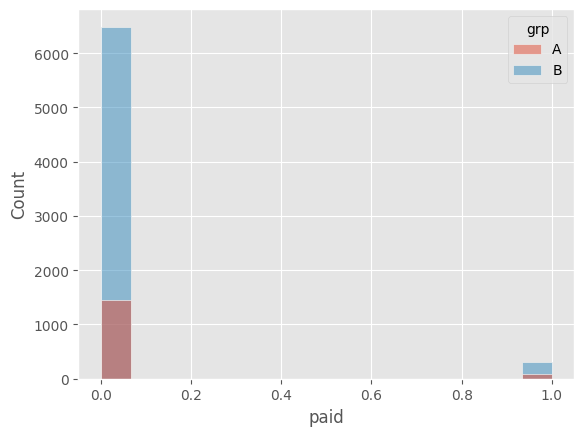

In [99]:
# Также визуализируем распределение конверсии в группах
sns.histplot(x='paid', 
             data=df_active[['grp','paid']], 
             hue='grp')


In [100]:
from scipy import stats
from scipy.stats import norm
import pingouin as pg

### ARPU

In [102]:
a_group = df_active.query('grp == "A"')
b_group = df_active.query('grp == "B"')

In [103]:
a_descr = a_group.rev.describe().to_frame().rename(columns={'rev': 'Group A'})
b_descr = b_group.rev.describe().to_frame().rename(columns={'rev': 'Group B'})
pd.concat([a_descr, b_descr], axis=1)

,Group A,Group B
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


In [104]:
# Считаем ARPU по двум группам. Наблюдается улучшение в тестовой группе
df_active.groupby('grp', as_index=False).rev.mean().rename(columns={'rev': 'ARPU'})

,grp,ARPU
0,A,47.347204
1,B,58.058798


In [105]:
# Ненормальное распределение в группах А и B
pg.normality(data=df_active, dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,2240.595797,0.0,False
B,7797.399212,0.0,False


### ARPPU

In [106]:
active_paid = df_active.query('rev > 0')
active_paid.head()

,id,grp,rev,paid
1,1627,A,990.0000,1
220,100300,B,990.0000,1
320,108270,B,290.0000,1
3779,264473,B,1900.0001,1
4187,274352,B,690.0000,1


In [107]:
a_group_paid = active_paid.query('grp == "A"')
b_group_paid = active_paid.query('grp == "B"')

In [108]:
a_paid_desc = a_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Group A'})
b_paid_desc = b_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Group B'})
pd.concat([a_paid_desc, b_paid_desc], axis=1)

,Group A,Group B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


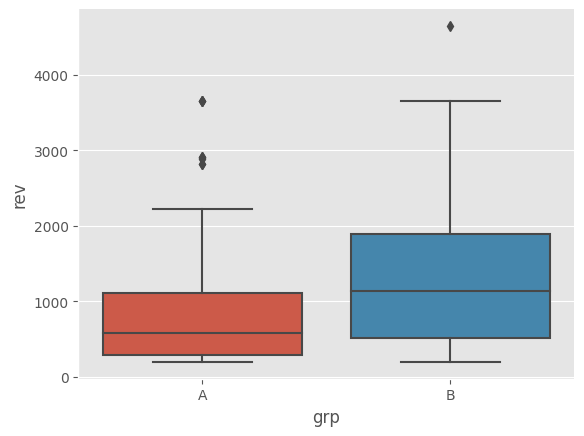

In [109]:
sns.boxplot(data=active_paid, y='rev', x='grp')
sns.despine()

Text(0.5, 0, 'Revenue')

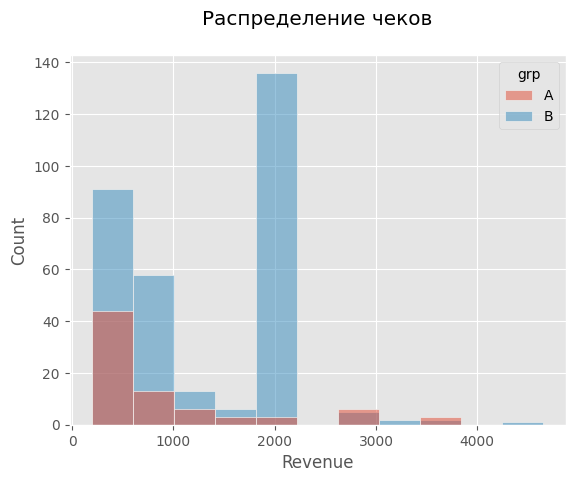

In [110]:
ax = sns.histplot(data = active_paid, x = 'rev', hue = 'grp')
ax.set_title('Распределение чеков\n')
ax.set_xlabel('Revenue')

In [111]:
# Ненормальное распределение в группах А и B
pg.normality(data=active_paid, dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


### Обзор метрик

Ответим на вопрос: Имеются ли различия в показателях и с чем они могут быть связаны?

In [112]:
metrics = df_active.groupby('grp', as_index = False)\
                    .agg({'id': 'count', 'paid': 'sum','rev': 'sum'})\
                    .rename(columns = {'id': 'users', 'paid': 'pay_users'})\
                    .assign(not_pay_users = lambda x: x.users - x.pay_users, \
                            arpu = lambda x:round((x.rev / x.users),2), \
                            arppu = lambda x: round((x.rev / x.pay_users),2),\
                            cr = lambda x: round((x.pay_users / x.users) * 100,2))
metrics
# в третьем задании для удобства будем использовать этот кусок кода

,grp,users,pay_users,rev,not_pay_users,arpu,arppu,cr
0,A,1538,78,72820.0000,1460,47.35,933.59,5.07
1,B,6803,314,394974.0035,6489,58.06,1257.88,4.62


In [113]:
df = metrics[['arpu', 'arppu', 'cr']] # для дальнейших расчетов возьму только необхлжимые колонки
df
# 0 - это A, 1 - B

,arpu,arppu,cr
0,47.35,933.59,5.07
1,58.06,1257.88,4.62


In [114]:
# ответим на вопрос есть ли разница между группой А и В 
# разницу каждой метрики, переведем в процент
# перезапишем в новую таблицу, чтоб красиво было 
diff_metrics = pd.DataFrame(round((-df.iloc[0] + df.iloc[1])/df.iloc[0]*100, 2)).T
diff_metrics

,arpu,arppu,cr
0,22.62,34.74,-8.88


1. изменение конверсии(CR) -8.88 %
2. изменение дохода с пользователя (ARPU) 22.62 %
3. изменение дохода с покупателя (ARPU) 34.74 %

Конверсия падает, но доход на пользователя/покупателя растёт

### Тесты

#### Note
Размеры групп сильно отличаются.  Плюс распределения в группах A и B не являются нормальными (были проведены тесты на нормальность). Буду применять bootstrap.

1. bootstrap распределения для групп А и B.
2. Определение их разницы.
3. В получившемся рапределении разницы определяем доверительный интервал.
4. Попадает ли доверительный интервал в 0.


In [115]:
# бутстрап
def get_bootstrap(
    data_col_1, # числовые значения первой выборки
    data_col_2, # числовые значения второй выборки
    boot_iter = 2000, # количество бутстрап-выборок
    statistic = np.mean, # интересующая статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_col_1), len(data_col_2))
    boot_data = []
    for i in range(boot_iter): # извлекаем подвыборки
        samples_1 = data_col_1.sample(
            boot_len,
            replace=True # параметр возвращения
        ).values
        
        samples_2 = data_col_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data))
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data,
            'ci': ci,
            'p_value': p_value}

### ARPU
(используем бустрап)

**Сформулируем нулевую и альтернативную гипотезы:**

 - **H0:** ARPU в двух группах одинаковые.
 - **H1:** ARPU в двух группах различаются.

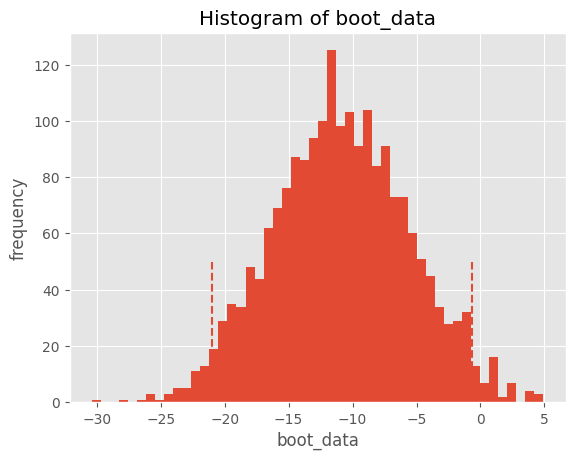

In [116]:
bootstrap_test_1 = get_bootstrap(a_group.rev, b_group.rev, boot_iter=2000)

In [117]:
bootstrap_test_1['ci']

,0
0.025,-20.968801
0.975,-0.700511


Ноль не входит в доверительный интервал - различия статистически значимы

In [118]:
bootstrap_test_1['p_value']

0.040094605236706396

p-value < 0.05

- Отклоняем нулевую гипотезу. 

##### Вывод по бутстрапу ARPU:
Средние значения в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

p-value < 0.05: имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

ARPU в двух группах различаются 

### ARPPU

**Сформулируем нулевую и альтернативную гипотезы:**

 - **H0:** ARPPU в двух группах одинаковые.
 - **H1:** ARPPU в двух группах различаются.

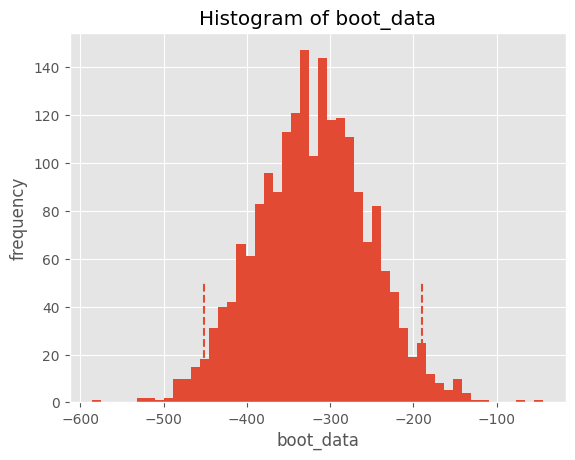

In [119]:
bootstrap_test_2 = get_bootstrap(a_group_paid.rev, b_group_paid.rev, boot_iter=2000)

In [120]:
bootstrap_test_2['ci']

,0
0.025,-450.865219
0.975,-189.888228


In [121]:
bootstrap_test_2['p_value']

1.9308521493907032e-06

p-value < 0.05
- Отклоняем нулевую гипотезу. 

##### Вывод (ARPPU):
ARPPU в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

p-value < 0.05 :  позволяет нам утверждать, что средние в двух группах отличаются статистически значимо

### CR

Расчет конверсии из вхождения на сайт в покупку кажется довольно целесообразной метрикой для сравнения. 

Из полученных ранее результатов в группе В конверия была ниже. Проверим значения на статистичесую значимость. 
Используем критерий хи-квадрат, так как переменные у нас категориальные.

 - **H0**: взаимосвязи между переменными нет
- **H1**: взаимосвязь есть

In [122]:
#Посмотрим на распределение пользователей купивших/некупивших в двух группах A/B
df_active.groupby('grp').paid.value_counts()

grp  paid
A    0       1460
     1         78
B    0       6489
     1        314
Name: paid, dtype: int64

In [123]:
grp_a = df_active[df_active['grp'] == 'A']
grp_b = df_active[df_active['grp'] == 'B']

In [124]:
a_pay = grp_a.paid.sum()
a_no_pay = grp_a.paid.size - grp_a.paid.sum()
b_pay = grp_b.paid.sum()
b_no_pay = grp_b.paid.size - grp_b.paid.sum()

In [125]:
cr_matrix = np.array([[a_pay, a_no_pay],
                        [b_pay, b_no_pay]])

In [126]:
cr_matrix

array([[  78, 1460],
       [ 314, 6489]], dtype=int64)

In [127]:
#прверяем дисперсии
pg.homoscedasticity(data=df_active, dv='paid', group='grp')

,W,pval,equal_var
levene,0.582052,0.445531,True


данные по конверсии по сути представляют собой категориальные величины (0 или 1), лучшим выбором будет критерий Хи-квадрат тк:
- наблюдения независимы
- Количество наблюдений в каждой ячейке больше 5

In [128]:
print(chi2_contingency(cr_matrix, correction=False))

Chi2ContingencyResult(statistic=0.5821513741106591, pvalue=0.44547028437158964, dof=1, expected_freq=array([[  72.28102146, 1465.71897854],
       [ 319.71897854, 6483.28102146]]))


**Вывод:** p_value>0.05, не отвергаем нулевую гипотезу (новая механика не влияет на решение о покупке)
(конверсии между двумя группами знамимых различий нет)

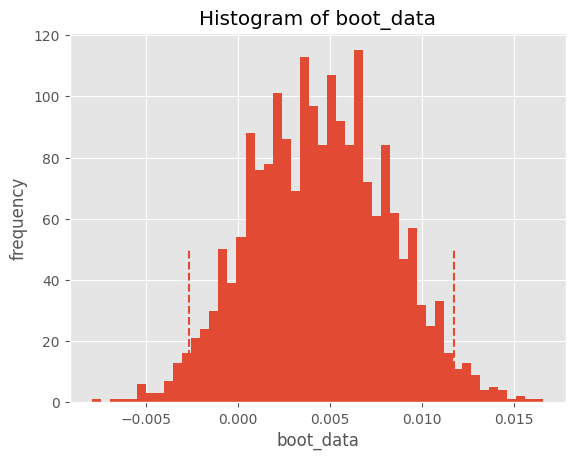

In [129]:
booted_data_cr = get_bootstrap(a_group.paid, b_group.paid, boot_iter=2000)

In [130]:
booted_data_cr['p_value']

0.22825555560015098

In [131]:
booted_data_cr['ci']

,0
0.025,-0.002646
0.975,0.011760


Дополнительно проведен бустрап.  0 - входит в ДИ. p-val > 0.05. Не отвергаем нулевую гипотезу. Различия между группами статистически незначимы

### Вывод


Положительное изменения по показателям ARPU и ARPPU, но негативные изменения по показателю CR

После проведения статистических тестов выяснилось, что ухудшение по CR статистически **не значимо**, позитивное изменение по ARPU, ARPPU статистически значимо.

В итоге: выкатываем новую механику оплаты на всех пользователей.


Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [141]:
def metrics_update(groups, group_add, active_studs, checks): 
    
    #перемименование колонок
    group_add.rename(columns = {group_add.columns[0]: 'id'}, inplace = True)
    groups.rename(columns = {groups.columns[0]: 'id'}, inplace = True)
    checks.rename(columns = {checks.columns[0]: 'id'}, inplace = True)
    active_studs.rename(columns = {active_studs.columns[0]: 'id'}, inplace = True)
    
    #собираем новый дф
    general = pd.concat([groups, group_add])
    df = general.merge(checks, on='id', how='left').fillna(0)
    df['is_active'] = df.id.isin(active_studs.id)
    
    #интересуют только активные пользователи
    df_active = df[(df.is_active)]
    #создание новой колонки
    df_active['paid'] = (df_active.rev != 0) * 1
    df_active.drop('is_active', inplace=True, axis=1)
    
    metrics = df_active.groupby('grp', as_index = False)\
                    .agg({'id': 'count', 'paid': 'sum','rev': 'sum'})\
                    .rename(columns = {'id': 'users', 'paid': 'pay_users', 'rev': 'total_money'})\
                    .assign(not_pay_users = lambda x: x.users - x.pay_users, \
                            arpu = lambda x:round((x.total_money / x.users),2), \
                            arppu = lambda x: round((x.total_money / x.pay_users),2),\
                            cr = lambda x: round((x.pay_users / x.users) * 100,2))
    metrics_1 = metrics[['grp', 'pay_users', 'not_pay_users', 'total_money', 'arpu', 'arppu', 'cr']]
    return (metrics_1)

In [142]:
result = metrics_update(groups, group_add, active_studs, checks)
result

,grp,pay_users,not_pay_users,total_money,arpu,arppu,cr
0,A,78,1460,72820.0000,47.35,933.59,5.07
1,B,314,6489,394974.0035,58.06,1257.88,4.62


In [143]:
def graphs(df):
    
    sns.set_theme(style = "whitegrid", )
    fig, axs = plt.subplots(ncols = 3, figsize = (18, 6))
    
    sns.barplot(x = "grp", y = "arpu", data = result, ax = axs[0]).set_title('ARPU')
    sns.barplot(x = "grp", y = "arppu", data = result, ax = axs[1]).set_title('ARPPU')
    sns.barplot(x = "grp", y = "cr", data = result, ax = axs[2]).set_title('CR')
    fig.show()

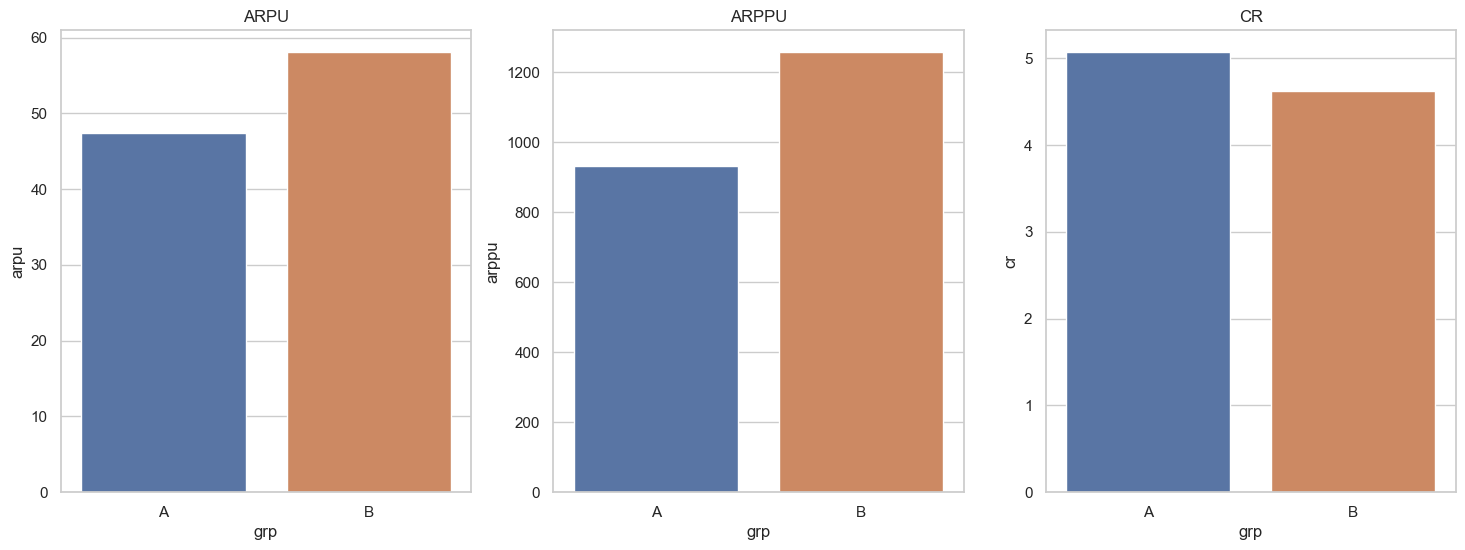

In [144]:
graphs(result)